In [1]:
import torch
import sys
import os
import json
import time
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

sys.path.append("..")
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructor
from singleVis.projector import DVIProjector
from singleVis.eval.evaluator import Evaluator

In [2]:
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" # DeepVisualInsight

In [19]:
CONTENT_PATH ="/home/xianglin/projects/DVI_data/resnet18_fmnist"
I = 25
GPU_ID = "0"

In [20]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [21]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
# GPU_ID = config["GPU"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, epoch_name="Epoch", device=DEVICE, classes=CLASSES,verbose=1)
if PREPROCESS:
    data_provider._meta_data()
    if B_N_EPOCHS >0:
        data_provider._estimate_boundary(LEN//10, l_bound=L_BOUND)

Finish initialization...


In [22]:
from singleVis.intrinsic_dim import IntrinsicDim
ID = IntrinsicDim(data_provider.train_representation(I))
dimension = ID.twonn_dimension_fast()
dimension

10.655119043298342

In [32]:
ENCODER_DIMS = [512,256,20]
DECODER_DIMS = [20,256,512]
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

In [33]:
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(I))
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
trainer = SingleVisTrainer(model, None, optimizer, None,edge_loader=None, DEVICE=DEVICE)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

embedded = projector.batch_project(I, data_provider.train_representation(I))

Successfully save visualization model...
Successfully load the DVI visualization model for iteration 25


In [34]:
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(I))
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
trainer = SingleVisTrainer(model, None, optimizer, None,edge_loader=None, DEVICE=DEVICE)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))
evaluator = Evaluator(data_provider, projector)
evaluator.eval_nn_train(I, 15)

Successfully save visualization model...
Successfully load the DVI visualization model for iteration 25
Sat Feb 25 16:24:30 2023 Building RP forest with 17 trees
Sat Feb 25 16:24:31 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Feb 25 16:24:33 2023 Building RP forest with 17 trees
Sat Feb 25 16:24:33 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
#train# nn preserving: 7.42/15 in epoch 25


7.4161

In [35]:
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

# Define DVI Loss
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)

# Define training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)

In [36]:
# Define Edge dataset
t0 = time.time()
spatial_cons = SingleEpochSpatialEdgeConstructor(data_provider, I, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS)
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct(data_provider.train_representation(I))
t1 = time.time()

Sat Feb 25 16:24:40 2023 Building RP forest with 17 trees
Sat Feb 25 16:24:41 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [37]:
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>1e-2#1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]

dataset = DataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=1000, sampler=sampler)

In [38]:
trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler,edge_loader=edge_loader, DEVICE=DEVICE)

t2=time.time()
trainer.train(PATIENT, MAX_EPOCH)
t3 = time.time()

epoch:1


100%|██████████| 1582/1582 [00:29<00:00, 53.59it/s]


umap:0.0681	recon_l:0.0026	loss:0.0733
epoch:2


100%|██████████| 1582/1582 [00:29<00:00, 52.93it/s]


umap:0.0651	recon_l:0.0016	loss:0.0683
epoch:3


100%|██████████| 1582/1582 [00:29<00:00, 53.85it/s]


umap:0.0650	recon_l:0.0016	loss:0.0683
epoch:4


100%|██████████| 1582/1582 [00:29<00:00, 53.40it/s]


umap:0.0650	recon_l:0.0016	loss:0.0682
epoch:5


100%|██████████| 1582/1582 [00:29<00:00, 52.95it/s]

umap:0.0632	recon_l:0.0012	loss:0.0656
Time spend: 148.31 for training vis model...


In [39]:
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(I))
trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

Successfully save visualization model...


In [40]:
evaluator = Evaluator(data_provider, projector)
evaluator.eval_nn_train(I, 15)

Successfully load the DVI visualization model for iteration 25
Sat Feb 25 16:27:12 2023 Building RP forest with 17 trees
Sat Feb 25 16:27:13 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Feb 25 16:27:15 2023 Building RP forest with 17 trees
Sat Feb 25 16:27:15 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 5.44/15 in epoch 25


5.436066666666667

In [13]:
evaluator = Evaluator(data_provider, projector)
evaluator.eval_nn_train(I, 15)

Successfully load the DVI visualization model for iteration 15
Sat Feb 25 15:06:33 2023 Building RP forest with 17 trees
Sat Feb 25 15:06:34 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Feb 25 15:06:36 2023 Building RP forest with 17 trees
Sat Feb 25 15:06:36 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 4.16/15 in epoch 15


4.158716666666667

In [27]:
train_repr = data_provider.train_representation(I)
train_data = projector.batch_project(I, train_repr)

Successfully load the DVI visualization model for iteration 15


In [28]:
import matplotlib.pyplot as plt
mesh_classes = np.arange(10)
color = plt.get_cmap("tab10")(mesh_classes / 9)
color = color[:, 0:3]
labels = data_provider.train_labels(I)
labels_color = color[labels]
plt.scatter(original_embedded[:, 0], original_embedded[:, 1],c=labels_color)
plt.show()

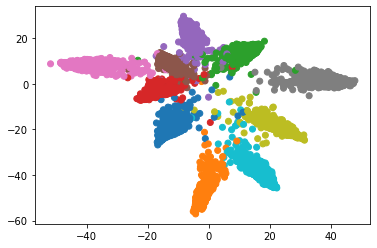

In [21]:
plt.scatter(original_embedded[:, 0], original_embedded[:, 1],c=labels_color)
plt.show()

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedded = pca.fit_transform(train_data)

In [53]:
pca.singular_values_

array([2290.7356, 2061.128 ], dtype=float32)

In [55]:
from singleVis.eval.evaluate import evaluate_proj_nn_perseverance_knn
val = evaluate_proj_nn_perseverance_knn(train_repr, train_data, n_neighbors=15, metric="euclidean")
val


Sat Feb 25 10:34:55 2023 Building RP forest with 17 trees
Sat Feb 25 10:34:56 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sat Feb 25 10:34:58 2023 Building RP forest with 17 trees
Sat Feb 25 10:34:58 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


4.585466666666667

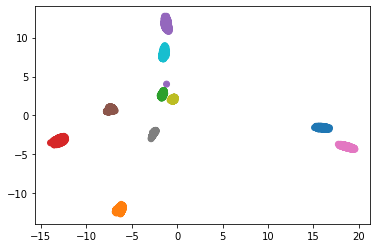

In [51]:
import matplotlib.pyplot as plt
plt.scatter(embedded[:, 0], embedded[:, 2],c=labels_color)
plt.show()

In [48]:
# intrinsic->low
intrinsic_embedded = projector.batch_project(I, embedded)

Successfully load the DVI visualization model for iteration 200


In [49]:
val = evaluate_proj_nn_perseverance_knn(train_repr, intrinsic_embedded, n_neighbors=15, metric="euclidean")
val

Sat Feb 25 10:16:15 2023 Building RP forest with 16 trees
Sat Feb 25 10:16:15 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Feb 25 10:16:17 2023 Building RP forest with 16 trees
Sat Feb 25 10:16:18 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


3.08782

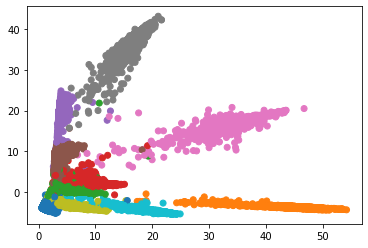

In [50]:
plt.scatter(intrinsic_embedded[:, 0], intrinsic_embedded[:, 1],c=labels_color)
plt.show()